In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from FVM_1D_jan2025 import fvm_1D
from coPINN_1D_Robin_Jan2025 import coPINN_1D_Solver

# device1 = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [2]:
L = 1.0

c_1 = 0.5 
c_2 = 10

h_c = 0.05
T_a = 300.0

alpha = 0.01
beta = 0.01

C_left = 0
C_right = 2

def S(T):
    return c_1*(-np.abs(np.sin(T)))

def Q(C):
    return c_2*(-1 + -1*np.abs(np.cos(C)))

def S_torch(T):
    return c_1*(-torch.abs(torch.sin(T)))

def Q_torch(C):
    return c_2*(-1 + -1*torch.abs(torch.cos(C)))

pde_related_funcs = {"heat_source_func":Q,"heat_source_func_torch":Q_torch,"conc_force_func":S,"conc_force_func_torch":S_torch}

problem_constants = {"L":L,"alpha":alpha,"beta":beta,"h_c":h_c,"T_a":T_a,"C_left":C_left,"C_right":C_right}

In [3]:
# N_x_1 = 500 #low TAKES APPROX 40 SECONDS
# tol_T = 1e-4
# tol_C = 1e-5

# T_FVM_1, C_FVM_1 = fvm_1D(pde_related_funcs,problem_constants,N_x_1,tol_T,tol_C)


# T_FVM_norm_1 = np.linalg.norm(T_FVM_1,2)
# C_FVM_norm_1 = np.linalg.norm(C_FVM_1,2)

# fvm_results_1 = {'T_FVM': T_FVM_1,'C_FVM':C_FVM_1,"T_FVM_norm":T_FVM_norm_1,"C_FVM_norm":C_FVM_norm_1}

In [4]:
# N_x_2 = 1000 #Medium TAKES APPROX 2.5 Minutes
# tol_T = 1e-4
# tol_C = 1e-5

# T_FVM_2, C_FVM_2 = fvm_1D(pde_related_funcs,problem_constants,N_x_2,tol_T,tol_C)


# T_FVM_norm_2 = np.linalg.norm(T_FVM_2,2)
# C_FVM_norm_2 = np.linalg.norm(C_FVM_2,2)

# fvm_results_2 = {'T_FVM': T_FVM_2,'C_FVM':C_FVM_2,"T_FVM_norm":T_FVM_norm_2,"C_FVM_norm":C_FVM_norm_2}

In [5]:
#IMPORTANT THIS MUST BE 2000
N_x_3 = 100 #High TAKES APPROX 4 Minutes
tol_T = 1e-1 #must be 1e-4
tol_C = 1e-1 #must be 1e-5

T_FVM_3, C_FVM_3 = fvm_1D(pde_related_funcs,problem_constants,N_x_3,tol_T,tol_C)

T_FVM_3 = T_FVM_3[:-1] #Removing the last element added for robin boundary


T_FVM_norm_3 = np.linalg.norm(T_FVM_3,2)
C_FVM_norm_3 = np.linalg.norm(C_FVM_3,2)

fvm_results_3 = {'T_FVM': T_FVM_3,'C_FVM':C_FVM_3,"T_FVM_norm":T_FVM_norm_3,"C_FVM_norm":C_FVM_norm_3}

Elapsed Time 0.156760


In [6]:
optimizer_algo = "LBFGS" #or Adam
# optimizer_algo = "Adam"
max_iter = 200 #200

N_f = 20000 #Total number of collocation points 

layers1 = np.array([1,50,50,50,50,1]) #9 hidden layers
layers2 = np.array([1,50,50,50,50,1]) #9 hidden layers

coPINN_constants = {"N_f":N_f,"max_iter" :max_iter,"layers1":layers1,"layers2":layers2,
                    "optimizer_algo":optimizer_algo,"device":device,"fvm_results":fvm_results_3}

In [7]:
coPINN_solver = coPINN_1D_Solver(coPINN_constants,pde_related_funcs,problem_constants,N_x_3)
coPINN_trained = coPINN_solver.train_model(1)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears1): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
  (linears2): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
1
0 Train Loss 315.8996 RD T: 0.6575504936347547 RD C: 0.6331761178979329
1 Train Loss 185.15411 RD T: 0.65900118670107 RD C: 0.5693907264483071
2 Train Loss 173.67787 RD T: 0.6412222652843336 RD C: 0.5701084744196452
3 Train Loss 161.79712 RD T: 0.5720186029111582 RD C: 0.5674105544831828
4 Train Loss 139.36398 RD T: 0.3837413327773073 RD C: 0.5705548651814258
5 Train Loss 84.90153 RD T: 0.15015052616901992 RD C: 0.5693344456784074
6 Train Loss 74.831055 RD T: 0.07103489544240899 RD C: 0.5698150

In [8]:
T_PINN,C_PINN = coPINN_trained.test()
# T_PINN = T_PINN.reshape(s[0],s[1])
# C_PINN = C_PINN.reshape(s[0],s[1])

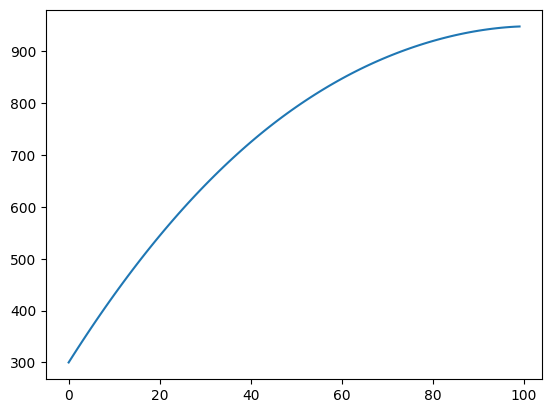

In [9]:
plt.plot(T_PINN)

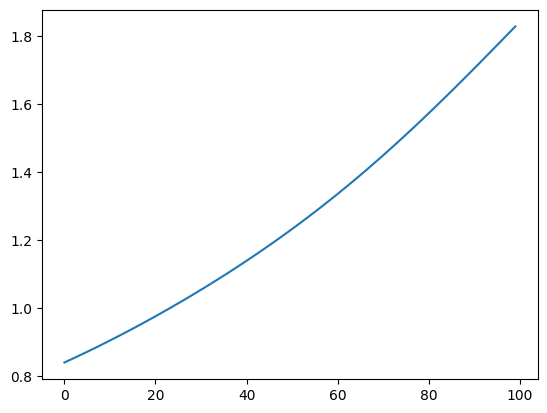

In [10]:
plt.plot(C_PINN)